# IZI_CODE
## Topic 1 : Optimizing the Positioning of Enedis Sites in Brittany

_____




### 🧠 Challenge
_________

Enedis has operational bases (OB) in the Brittany region:
- Bases are the starting points for technicians in the event of an incident
- Better positioning reduces:
    - Travel time
    - The duration of outages for customers
 

> **The current positioning of the BOs means longer response times due to long distances involved.**


### 🎯 Goal
________

The aim of the project is to optimize the location of Enedis' operational bases (OB) in Brittany. 

Meaning:
1. Determine the optimal towns to locate the OBs
2. Determine the communes attached to each OB
    - Constraint: Each commune must be attached to a BO located less than 30 minutes away


### 🧾 Data
_________

- `communes_bre.csv`: Current map of activity zones
- `temps_trajet30.csv`: Travel times between communes 
- `niveau_interventions.csv`: Annual intervention volumes by commune



In [524]:
import json, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import folium, geopandas
from shapely.geometry import MultiPolygon

______
# I.1. Treatment of communes

In [44]:
commune_df = pd.read_csv('../data/sujet-1/communes_bre.csv', delimiter=';')
print(f"Shape : {commune_df.shape}")
commune_df.head()

Shape : (1207, 40)


Geo Point  \
0     47.8871419559671,-4.164161134106372   
1   48.446702017978325,-4.463235727523395   
2   48.483723613082205,-4.040465447415241   
3      48.4663585550616,-4.63454521582595   
4  48.098082470115166,-4.2131596293762605   

                                           Geo Shape  Année  \
0  {"coordinates": [[[-4.207834306492863, 47.8934...   2022   
1  {"coordinates": [[[-4.430899994092384, 48.4591...   2022   
2  {"coordinates": [[[-4.016507113583825, 48.5016...   2022   
3  {"coordinates": [[[-4.612667187306825, 48.4833...   2022   
4  {"coordinates": [[[-4.201967882377015, 48.1118...   2022   

   Code Officiel Région Nom Officiel Région  Code Officiel Département  \
0                    53            Bretagne                         29   
1                    53            Bretagne                         29   
2                    53            Bretagne                         29   
3                    53            Bretagne                         29   
4                    53            Bretagne                         29   

  Nom Officiel Département  Code Officiel Arrondissement départemental  \
0                Finistère                                         294   
1                Finistère                                         291   
2                Finistère                                         293   
3                Finistère                                         291   
4                Finistère                                         294   

  Nom Officiel Arrondissement départemental  Code Officiel Zone emploi 2020  \
0                                   Quimper                            5313   
1                                     Brest                            5302   
2                                   Morlaix                            5310   
3                                     Brest                            5302   
4                                   Quimper                            5313   

   ... Code AU2010  Code CATEAAV2020              Libellé CATEAAV2020  \
0  ...         NaN                20           Commune de la couronne   
1  ...         NaN                20           Commune de la couronne   
2  ...         NaN                12  Autre commune du pôle principal   
3  ...         NaN                20           Commune de la couronne   
4  ...         NaN                20           Commune de la couronne   

   Code UU2020 Statut Commune UU2020  Code AAV2020  Code Canton Ville  \
0        29308         unité urbaine            52               2919   
1        29701         unité urbaine            32               2904   
2        29302         unité urbaine           289               2914   
3        29000    hors unité urbaine            32               2927   
4        29000    hors unité urbaine            52               2923   

   Fait Partie d'une CTU      SIREN Zone Montagne  
0                    Non  212900377           Non  
1                    Non  212900617           Non  
2                    Non  212900971           Non  
3                    Non  212901193           Non  
4                    Non  212901342           Non  

[5 rows x 40 columns]

### Proportion of missing values per column

Here, we visualizes the missing data (NaN) using a heatmap:
- Missing values are quickly identified with white zones
- We can then decide which columns to drop or impute based on the amount of missing data

In [40]:
100 * commune_df.isna().sum() / len(commune_df)

Geo Point                                       0.00000
Geo Shape                                       0.00000
Année                                           0.00000
Code Officiel Région                            0.00000
Nom Officiel Région                             0.00000
Code Officiel Département                       0.00000
Nom Officiel Département                        0.00000
Code Officiel Arrondissement départemental      0.00000
Nom Officiel Arrondissement départemental       0.00000
Code Officiel Zone emploi 2020                  0.00000
Nom Officiel Zone emploi 2020                   0.00000
Code Officiel Bassin vie 2012                   0.00000
Nom Officiel Bassin vie 2012                    0.00000
Code Officiel EPCI                              0.24855
Nom Officiel EPCI                               0.24855
Code Officiel EPT                             100.00000
Nom Officiel EPT                              100.00000
Code Officiel Commune                           

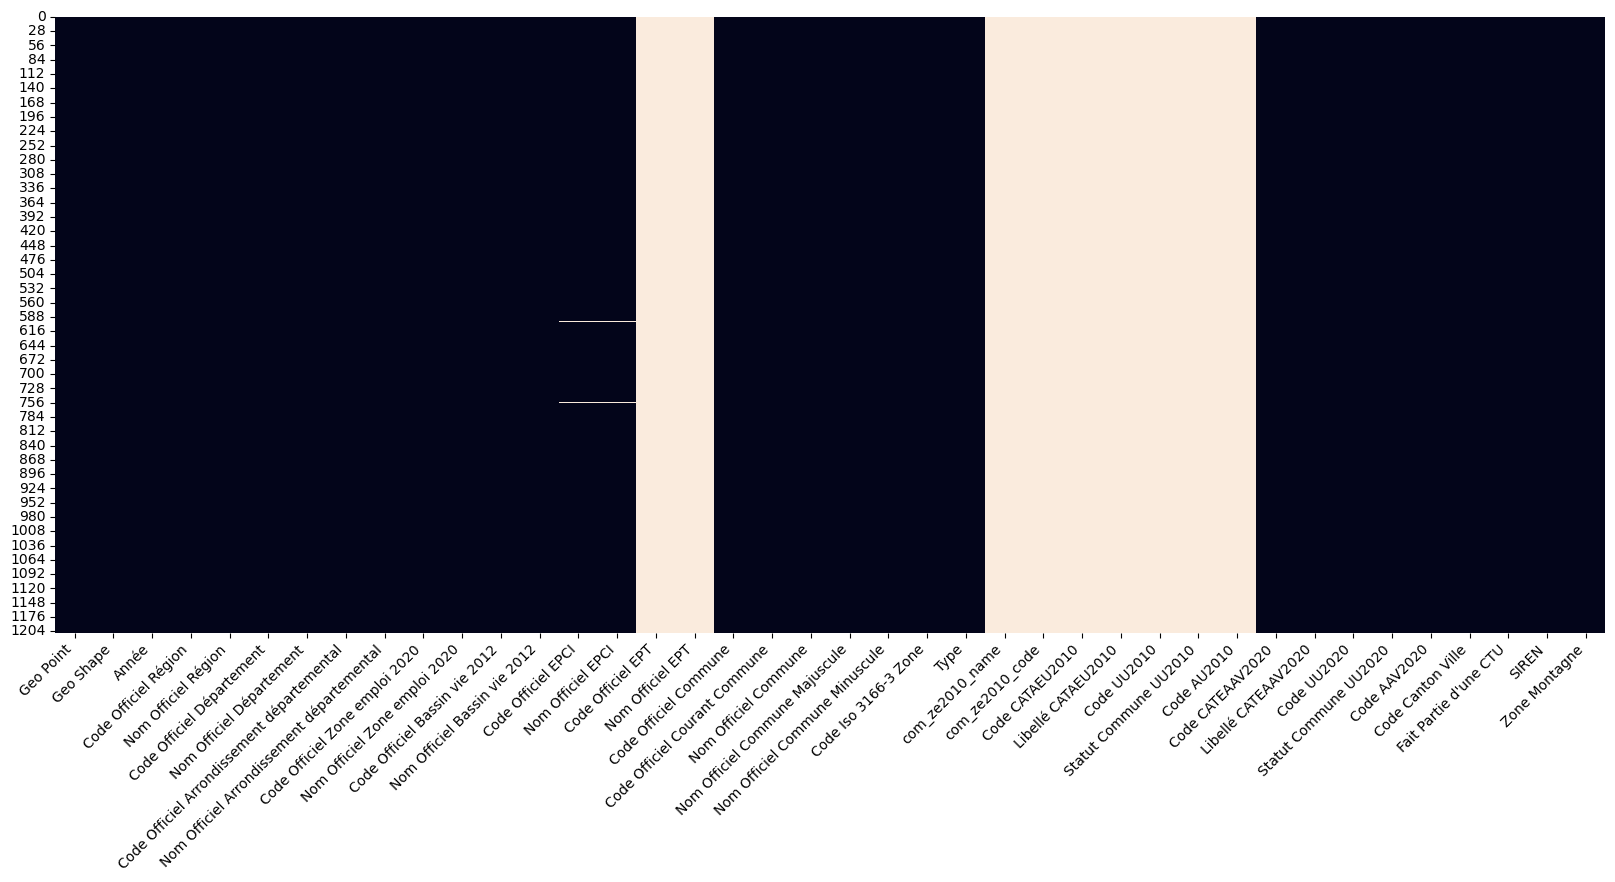

In [46]:
plt.figure(figsize=(20, 8))
sns.heatmap(commune_df.isna(), cbar=False)
plt.xticks(rotation=45, ha='right')
plt.show()

### Features Selection

According to the subject's recommendations, we select the most relevant columns from this dataset: 

`Geo Point`, `Nom Officiel Commune Majuscule`, `Code Officiel Commune`


In [47]:
commune_df = commune_df[['Geo Point', 'Nom Officiel Commune Majuscule', 'Code Officiel Commune']]
print("Column Types: \n")
print(commune_df.dtypes)
commune_df.head()

Column Types: 

Geo Point                         object
Nom Officiel Commune Majuscule    object
Code Officiel Commune              int64
dtype: object


Geo Point Nom Officiel Commune Majuscule  \
0     47.8871419559671,-4.164161134106372                        COMBRIT   
1   48.446702017978325,-4.463235727523395                       GOUESNOU   
2   48.483723613082205,-4.040465447415241              LAMPAUL-GUIMILIAU   
3      48.4663585550616,-4.63454521582595                     LANRIVOARÉ   
4  48.098082470115166,-4.2131596293762605                       LOCRONAN   

   Code Officiel Commune  
0                  29037  
1                  29061  
2                  29097  
3                  29119  
4                  29134

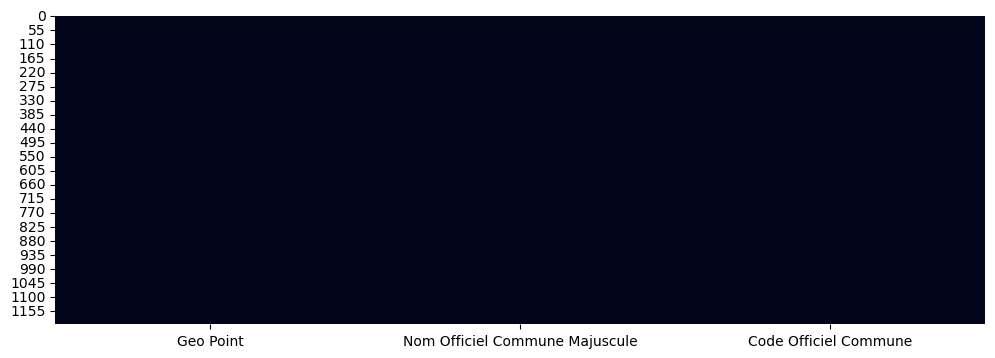

In [48]:
plt.figure(figsize=(12, 4))
sns.heatmap(commune_df.isna(), cbar=False)
plt.show()

We process the geographical data by splitting the `Geo Point` column, which contains `longitude` and `latitude` values, into two separate numeric columns. This is essential for enabling spatial analysis, such as distance calculations and map visualizations

In [49]:
# Split the 'Geo Point' column into 'longitude' and 'latitude'
commune_df[['longitude', 'latitude']] = commune_df['Geo Point'].str.split(',', expand=True)

# Drop 'Geo Point' column
commune_df.drop('Geo Point', axis=1, inplace=True)

# Rename the columns
commune_df.columns = ['nom', 'code', 'longitude', 'latitude']

# Set 'code' as index
commune_df.set_index('code', inplace=True)
commune_df.head()

nom           longitude             latitude
code                                                             
29037            COMBRIT    47.8871419559671   -4.164161134106372
29061           GOUESNOU  48.446702017978325   -4.463235727523395
29097  LAMPAUL-GUIMILIAU  48.483723613082205   -4.040465447415241
29119         LANRIVOARÉ    48.4663585550616    -4.63454521582595
29134           LOCRONAN  48.098082470115166  -4.2131596293762605

______
# I.2. Treatment of Intervention levels

In [145]:
niv_df = pd.read_csv('../data/sujet-1/niveau_interventions.csv', delimiter=';', encoding='latin-1')
print(niv_df.shape)
niv_df.head()

(1208, 3)


code_insee_commune Niveau d'activité clientèle Niveau d'activité réseau
0               22001                         Bas                      Bas
1               22002                         Bas                     Haut
2               22003                         Bas                 Très Bas
3               22004                   Très Haut                Très Haut
4               22005                       Moyen                     Haut

In [146]:
niv_df.columns = ['code', 'nivC', 'nivR']
niv_df.set_index(['code'], inplace=True)
niv_df.head()

nivC       nivR
code                       
22001        Bas        Bas
22002        Bas       Haut
22003        Bas   Très Bas
22004  Très Haut  Très Haut
22005      Moyen       Haut

## Intervention levels

We encoded the qualitative information on intervention levels (`nivC` and `nivR`) into numerical values to facilitate processing:
- Algorithms require numerical data to perform operations
- Encoding makes it possible to standardize levels, so that communes can be compared objectively

Then:
- We calculated an average of the two levels to obtain an overall indicator `nivIntervention`, easier to interpret
- We assigned a color to each level to enable intuitive visualization on maps or graphs

In [147]:
print(niv_df['nivC'].unique().tolist())
print(niv_df['nivR'].unique().tolist())

['Bas', 'Très Haut', 'Moyen', 'Très Bas', 'Haut']
['Bas', 'Haut', 'Très Bas', 'Très Haut', 'Moyen']


In [148]:
# Encoding levels into numerical values
level_map = {
    'Très Bas': 1,
    'Bas': 2,
    'Moyen': 3,
    'Haut': 4,
    'Très Haut': 5
}

# Colors associated with levels for visualization
color_map = {
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red'
}

# Encoding 
niv_df[['nivC', 'nivR']] = niv_df[['nivC', 'nivR']].map(level_map.get)
# Average of the two intervention levels
niv_df['nivIntervention'] = (niv_df[['nivC', 'nivR']].sum(axis=1) / 2).astype(int)
# Assign color to each level
niv_df['color'] = niv_df['nivIntervention'].map(color_map)
niv_df.head()

nivC  nivR  nivIntervention   color
code                                      
22001     2     2                2   green
22002     2     4                3  yellow
22003     2     1                1    blue
22004     5     5                5     red
22005     3     4                3  yellow

# I.3. Treatment of Travel time

In [85]:
trajet_df = pd.read_csv('../data/sujet-1/temps_trajet30.csv', delimiter=';', encoding='latin-1')
print(trajet_df.shape)
trajet_df.head()

(84495, 3)


depart  destination  durée
0  COMBRIT      COMBRIT    0.0
1  COMBRIT     ÎLE-TUDY  475.5
2  COMBRIT      TRÉMÉOC  561.8
3  COMBRIT  PONT-L'ABBÉ  558.4
4  COMBRIT    GOUESNACH  868.6

We start by checking:
- How many different communes are present
- The symmetrical difference between `depart` and `destination` to detect any inconsistencies 

In [105]:
print(trajet_df['depart'].nunique(), trajet_df['depart'].unique(), end="\n\n")
print(trajet_df['destination'].nunique(), trajet_df['destination'].unique(), end="\n\n")
print(set(trajet_df['depart'].unique().tolist()).symmetric_difference(set(trajet_df['destination'].unique().tolist())))

1201 ['COMBRIT' 'GOUESNOU' 'LAMPAUL-GUIMILIAU' ... 'LANVALLAY' 'MONTGERMONT'
 'SAINT-GRÉGOIRE']

1201 ['COMBRIT' 'ÎLE-TUDY' 'TRÉMÉOC' ... 'BANGOR' 'SAUZON' 'OUESSANT']

set()


We can see that there are travels where the commune of departure is the same as the commune of arrival:
- These routes may be excluded from our analyses
- We also check that for these specific travels, there are no durations greater than 0, which could raise questions

In [111]:
tmp = trajet_df[trajet_df['depart']==trajet_df['destination']]
print(tmp.shape)
print(tmp['durée'].max())
tmp.head()

(1207, 3)
0.0


depart        destination  durée
0              COMBRIT            COMBRIT    0.0
70            GOUESNOU           GOUESNOU    0.0
140  LAMPAUL-GUIMILIAU  LAMPAUL-GUIMILIAU    0.0
210         LANRIVOARÉ         LANRIVOARÉ    0.0
280           LOCRONAN           LOCRONAN    0.0

- We check the presence of duplicated travels (there are 420)
- We check that there is no more than one different duration for each pair (departure, destination)

In [126]:
trajet_df.duplicated().sum()

420

In [128]:
diff_duree = trajet_df.groupby(['depart', 'destination'])['durée'].nunique()
diff_duree[diff_duree > 1]

Series([], Name: durée, dtype: int64)

### Cleaning trip times

To respect the constraint that each commune should be linked only to BO within 30 minutes travel time:
- We filtered out any travel longer than 30 minutes (1800seconds)
- This helps to focus on relevant travel times
- We remove duplicate rows to ensure clean and accurate data for the analysis

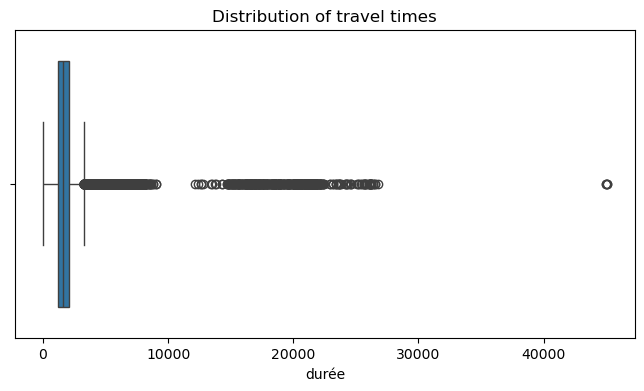

In [133]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=trajet_df['durée'])
plt.title("Distribution of travel times")
plt.show()

In [135]:
# Remove outliers 
trajet_df = trajet_df[trajet_df['durée'] <= 1800]
trajet_df.reset_index(inplace=True, drop=True)
# Remove duplicate rows  
trajet_df = trajet_df[trajet_df.duplicated() == False]

print(trajet_df.shape)
trajet_df.head()

(51767, 3)


depart  destination  durée
0  COMBRIT      COMBRIT    0.0
1  COMBRIT     ÎLE-TUDY  475.5
2  COMBRIT      TRÉMÉOC  561.8
3  COMBRIT  PONT-L'ABBÉ  558.4
4  COMBRIT    GOUESNACH  868.6

_______
# II.1. Merging Commune and Intervention level


In [169]:
df = pd.merge(niv_df[["nivIntervention", "color"]], commune_df, left_index=True, right_index=True, how='inner')
df = df.astype({"longitude": float, "latitude": float}) 
df = df[["nom", "longitude", "latitude", "nivIntervention", "color"]]

print(df.shape)
df.head()

(1206, 5)


nom  longitude  latitude  nivIntervention   color
code                                                                    
22001             ALLINEUC  48.311574 -2.867065                2   green
22002                ANDEL  48.494105 -2.551043                3  yellow
22003             AUCALEUC  48.451792 -2.127619                1    blue
22004               BÉGARD  48.634784 -3.291537                5     red
22005  BELLE-ISLE-EN-TERRE  48.531066 -3.381838                3  yellow

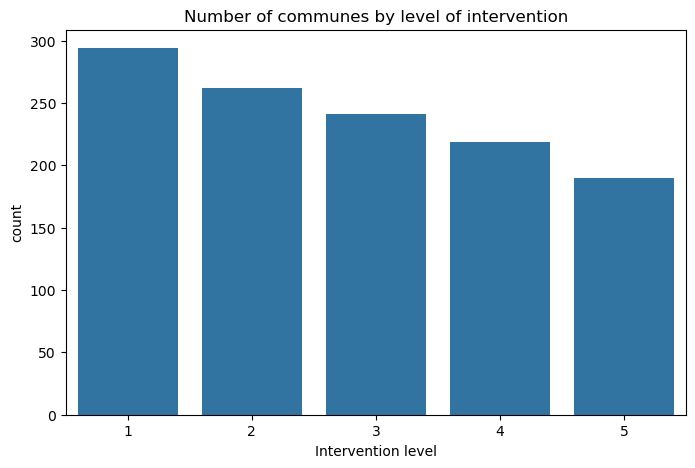

In [168]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="nivIntervention")
plt.xlabel("Intervention level")
plt.title("Number of communes by level of intervention")
plt.show()

_______
# II.2. Merging with Travel time

In [220]:
dff = pd.merge(trajet_df, df, left_on="depart", right_on="nom", how="inner")
dff.drop(["nom"], axis=1, inplace=True)

dff = dff.rename(columns={"longitude": "LongitudeDepart", "latitude": "LatitudeDepart"})
print(dff.shape)
dff.head()

(51706, 7)


depart  destination  durée  LongitudeDepart  LatitudeDepart  \
0  COMBRIT      COMBRIT    0.0        47.887142       -4.164161   
1  COMBRIT     ÎLE-TUDY  475.5        47.887142       -4.164161   
2  COMBRIT      TRÉMÉOC  561.8        47.887142       -4.164161   
3  COMBRIT  PONT-L'ABBÉ  558.4        47.887142       -4.164161   
4  COMBRIT    GOUESNACH  868.6        47.887142       -4.164161   

   nivIntervention color  
0                5   red  
1                5   red  
2                5   red  
3                5   red  
4                5   red

# Visualisation

In [204]:
dfw_geo_ = geopandas.read_file('../data/sujet-1/geoFR.geojson')

Skipping field reg_code: unsupported OGR type: 5
Skipping field reg_name: unsupported OGR type: 5
Skipping field dep_code: unsupported OGR type: 5
Skipping field dep_name: unsupported OGR type: 5
Skipping field arrdep_code: unsupported OGR type: 5
Skipping field arrdep_name: unsupported OGR type: 5
Skipping field ze2020_code: unsupported OGR type: 5
Skipping field ze2020_name: unsupported OGR type: 5
Skipping field bv2012_code: unsupported OGR type: 5
Skipping field bv2012_name: unsupported OGR type: 5
Skipping field epci_code: unsupported OGR type: 5
Skipping field epci_name: unsupported OGR type: 5
Skipping field com_code: unsupported OGR type: 5
Skipping field com_current_code: unsupported OGR type: 5
Skipping field com_name: unsupported OGR type: 5


In [216]:
dff.head()

Depart  Destination  Duree  Longitudedepart  Latitudedepart  \
0  COMBRIT      COMBRIT    0.0        47.887142       -4.164161   
1  COMBRIT     ÎLE-TUDY  475.5        47.887142       -4.164161   
2  COMBRIT      TRÉMÉOC  561.8        47.887142       -4.164161   
3  COMBRIT  PONT-L'ABBÉ  558.4        47.887142       -4.164161   
4  COMBRIT    GOUESNACH  868.6        47.887142       -4.164161   

   Nivintervention Color  
0                5   red  
1                5   red  
2                5   red  
3                5   red  
4                5   red

In [217]:
df.head()

nom  longitude  latitude  nivIntervention   color
code                                                                    
22001             ALLINEUC  48.311574 -2.867065                2   green
22002                ANDEL  48.494105 -2.551043                3  yellow
22003             AUCALEUC  48.451792 -2.127619                1    blue
22004               BÉGARD  48.634784 -3.291537                5     red
22005  BELLE-ISLE-EN-TERRE  48.531066 -3.381838                3  yellow

In [224]:
dfw_geo = dfw_geo_.copy()
dfw_geo.rename(columns = {'com_uu2020_code': 'code'}, inplace=True)
dfw_geo.set_index(['code'], inplace=True)
dfw_geo = dfw_geo[['geometry', 'com_name_upper']]

#dfw_geo = dfw_geo.merge(dff, left_on='com_name_upper', right_on='depart', how='inner')
dfw_geo = dfw_geo.merge(df, left_on='com_name_upper', right_on='nom', how='inner')
dfw_geo.drop(['com_name_upper'], axis=1, inplace=True)
dfw_geo = dfw_geo[dfw_geo.isna()==False]
dfw_geo = dfw_geo.dropna(axis=0)

print(dfw_geo.shape)
dfw_geo.head()

(1218, 6)


geometry                nom  \
0  POLYGON ((-4.20783 47.89344, -4.20724 47.89301...            COMBRIT   
1  POLYGON ((-4.4309 48.45915, -4.43146 48.45949,...           GOUESNOU   
2  POLYGON ((-4.01651 48.5016, -4.01692 48.50198,...  LAMPAUL-GUIMILIAU   
3  POLYGON ((-4.61267 48.48335, -4.6129 48.48358,...         LANRIVOARÉ   
4  POLYGON ((-4.20197 48.1118, -4.20242 48.11062,...           LOCRONAN   

   longitude  latitude  nivIntervention   color  
0  47.887142 -4.164161                5     red  
1  48.446702 -4.463236                5     red  
2  48.483724 -4.040465                4  orange  
3  48.466359 -4.634545                2   green  
4  48.098082 -4.213160                2   green

### Communes by Intervention level

We first plot all communes in a neutral grey, providing an overall geographic context

Then we plot each commune according to its intervention level. This helps:
- Quickly identify disparities in intervention needs 
- Adopt a strategy for prioritizing and allocating resources effectively across the territory

<br> 

The graph shows a large number of high and very high intervention zones:
> **Given that intervention levels are also crucial, our hypothesis is to prioritize locating a OB in communes with a high intervention level (>= 4) instead of just considering proximity**

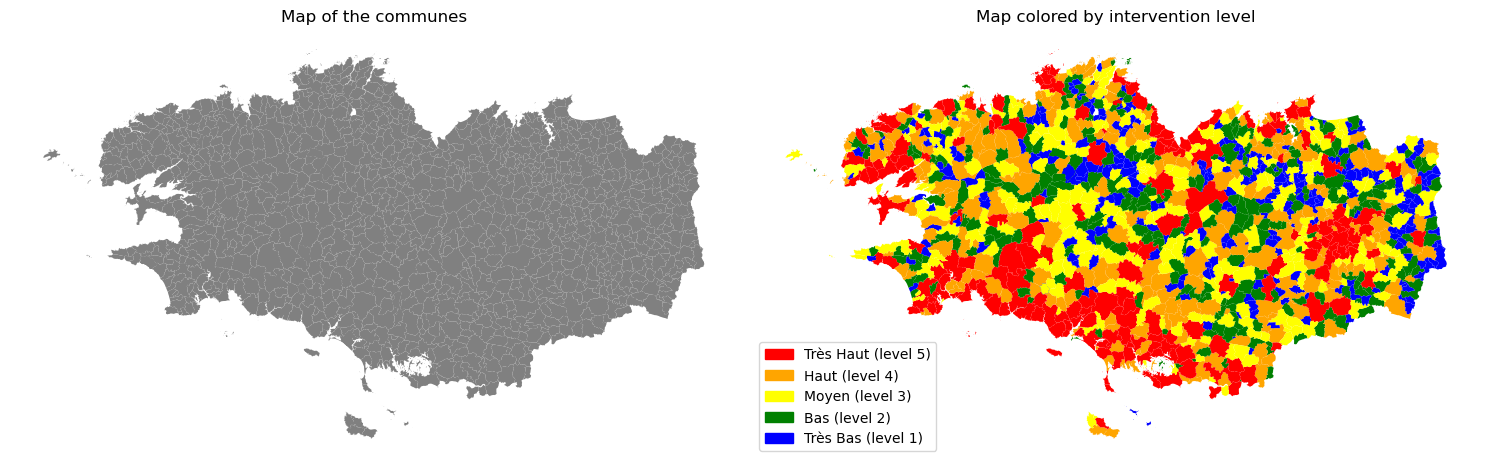

In [243]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# Plot map of communes
dfw_geo.plot(ax=axes[0], color='grey')
axes[0].set_title("Map of the communes")
axes[0].axis('off')

# Plot map colored by intervention level
dfw_geo.plot(ax=axes[1], color=dfw_geo['color'])
axes[1].set_title("Map colored by intervention level")
axes[1].axis('off')

# Legend patches
r_legend = mpatches.Patch(color='red', label='Très Haut (level 5)')
orange_legend = mpatches.Patch(color='orange', label='Haut (level 4)')
y_legend = mpatches.Patch(color='yellow', label='Moyen (level 3)')
g_legend = mpatches.Patch(color='green', label='Bas (level 2)')
b_legend = mpatches.Patch(color='blue', label='Très Bas (level 1)')
axes[1].legend(handles=[r_legend, orange_legend, y_legend, g_legend, b_legend], loc='lower left')
plt.tight_layout()
plt.show()

____________
# III. Modelling

In [258]:
dfw_geo['nom'].nunique()

1200


For the modeling, we defined specific constraints:
- Each operational base (OB) must be able to manage between 50 and 60 communes
- Given that we have around 1200 communes, we must have between 20 and 40 clusters

First, we chose to consider only geographic proximity as the clustering criterion:
- Therefore, we used only `longitude` and `latitude` columns
- To determine the optimal number of clusters, we applied the **Elbow Method** and **Silhouette Score** 

### III.1. Finding the best `k` (Number of clusters)


`init=k-means++` is a smarter way to initialize cluster centroids. Instead of picking starting points randomly, it selects them based on how much they would improve the clustering (inertia)

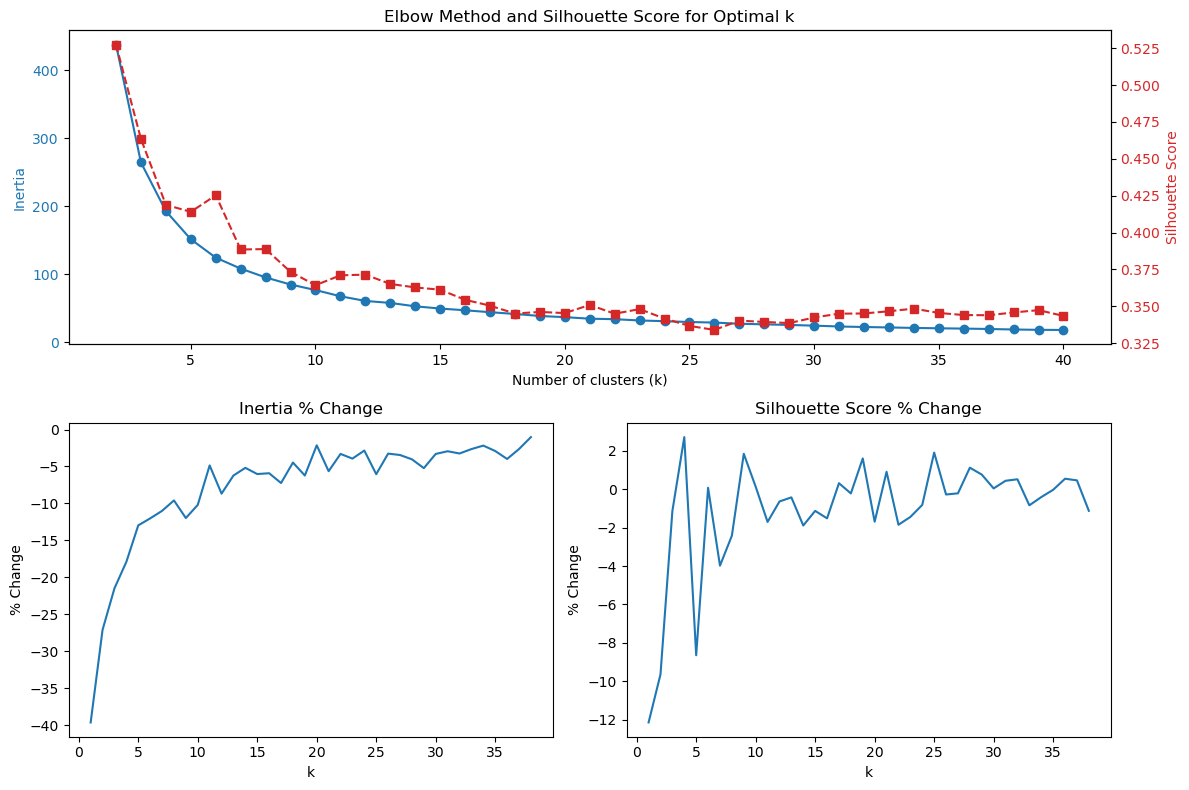

In [361]:
inertia = []
sil_scores = []
K_range = range(2, 41)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    sil_scores.append(metrics.silhouette_score(X, labels))
    

fig, axes = plt.subplot_mosaic(
    """
    11
    23
    """, figsize=(12, 8)
)

# Plot Elbow method + Silhouette score
ax1 = axes['1']
color1 = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color=color1)
ax1.plot(K_range, inertia, 'o-', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(K_range, sil_scores, 's--', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_title('Elbow Method and Silhouette Score for Optimal k')

# Plot Inertia % change
pd.Series(inertia).pct_change().mul(100).plot(ax=axes['2'])
axes['2'].set_title("Inertia % Change")
axes['2'].set_xlabel("k")
axes['2'].set_ylabel("% Change")

# Plot Silhouette Score % change
pd.Series(sil_scores).pct_change().mul(100).plot(ax=axes['3'])
axes['3'].set_title("Silhouette Score % Change")
axes['3'].set_xlabel("k")
axes['3'].set_ylabel("% Change")
plt.tight_layout()
plt.show()

### k=21 Cluster

From the analysis:
- The inertia curve showed a significant drop up to around k = 21, after which the gain diminishes (elbow point) 
- The silhouette score remained stable and acceptable around k = 21, indicating consistent cluster quality
- `k=21` represents a balanced trade-off between cluster compactness, separation and number of OBs

In [505]:
def plot_cluster(kmeans, dfw_geo, X, fig_title):
    labels = kmeans.labels_
    k = kmeans.n_clusters    
    print("Inertia : ", kmeans.inertia_)
    print("Calinski Score : ", metrics.calinski_harabasz_score(X, labels))
    print("Silouhette Score: ", metrics.silhouette_score(X, labels, metric='euclidean'), end="\n\n")

    # Average intervention level by cluster
    tmp = dfw_geo.copy()
    tmp['centroid'] = labels
    
    # Group by cluster and dissolve geometries
    cluster_boundaries = tmp.dissolve(by='centroid')
    centroids_coords = kmeans.cluster_centers_
    
    # Map colors
    avg_intervt_level = tmp.groupby('centroid')['nivIntervention'].mean().round().astype(int)
    cluster_colors = avg_intervt_level.map(color_map)
    cluster_colors_by_intervnt_level = tmp['centroid'].map(cluster_colors)
    cmap = cm.get_cmap('tab20', k)   
    cluster_colors = [cmap(i) for i in range(k)]
    cluster_colors_by_centroid = [cluster_colors[label] for label in kmeans.labels_]

    # Plot map colored by intervention level
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    fig.suptitle(f"{fig_title}", fontsize=16, fontweight='bold', y=0.77)
    dfw_geo.plot(ax=axs[0], color=dfw_geo['color'])
    axs[0].set_title("Map colored by intervention level")
    axs[0].axis('off')
    axs[0].legend(handles=[r_legend, orange_legend, y_legend, g_legend, b_legend], loc='lower left')
    # Plot Scatter plot of clusters with centroids
    tmp.plot(ax=axs[1], color=cluster_colors_by_centroid, edgecolor='black', linewidth=0.3)
    cluster_boundaries.boundary.plot(ax=axs[1], color='black', linewidth=1.5)
    axs[1].scatter(centroids_coords[:, 0], centroids_coords[:, 1], color='r', marker='*', s=200, label='Centroids')
    axs[1].set_title(f"{k}-Clusters")
    axs[1].axis('off')
    
    # Plot Map with cluster colors
    tmp.plot(ax=axs[2], color=cluster_colors_by_intervnt_level, edgecolor='black', linewidth=0.3)
    # boundaries
    cluster_boundaries.boundary.plot(ax=axs[2], color='black', linewidth=1.5)
    axs[2].scatter(centroids_coords[:, 0], centroids_coords[:, 1], color='r', marker='*', s=200, label='Centroids')
    axs[2].set_title(f"{k}-Clusters by average intervention level")
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()

Inertia :  34.30856781151916
Calinski Score :  2133.541778312532
Silouhette Score:  0.35086764079263505



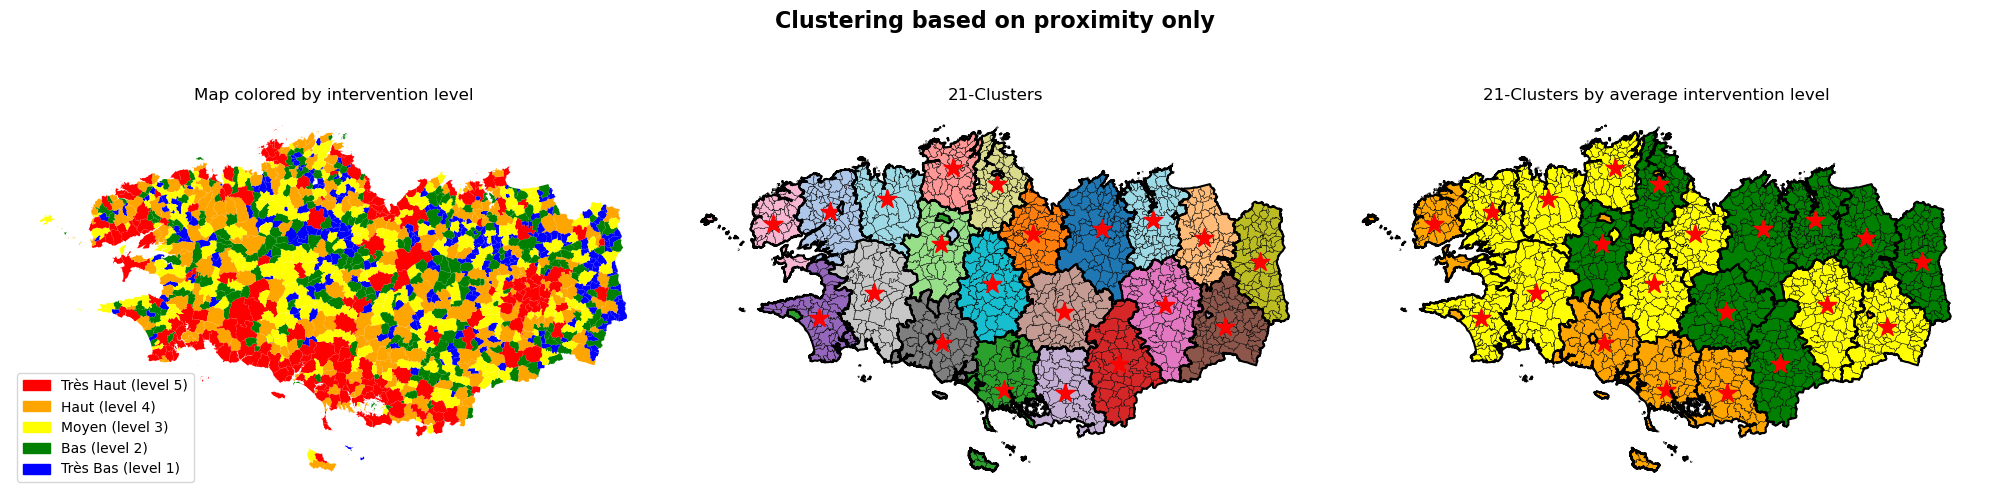

In [506]:
k = 21
X = np.array(dfw_geo[['latitude', 'longitude']])
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
kmeans.fit(X)

plot_cluster(kmeans, dfw_geo, X, fig_title="Clustering based on proximity only")

### III.2. Introducing Weights in KMeans

We introduced sample weights in the KMeans clustering to better reflect the operational workload of each commune. 
Instead of treating all communes equally:
- We gave more importance to those with longer average intervention durations
- We balanced in terms of effort needed, resulting in more realistic and efficient zones for operational planning

In [509]:
# Retrieve average duration per commune
avg_duration = dff.groupby('depart')[['durée']].mean()

# If a commune is missing from the duration table, fill with the global mean
default_duration = avg_duration['durée'].mean()
weights_duration = dfw_geo['nom'].map(avg_duration['durée']).fillna(default_duration)

###  III.2.a. Clustering integrating Average Travel Time:
- Greater importance given to communes with longer intervention times
- Communes with longer durations will have more impact on the position of cluster centers

Inertia :  42300.57613385131
Calinski Score :  2075.721328845217
Silouhette Score:  0.3409436240746106



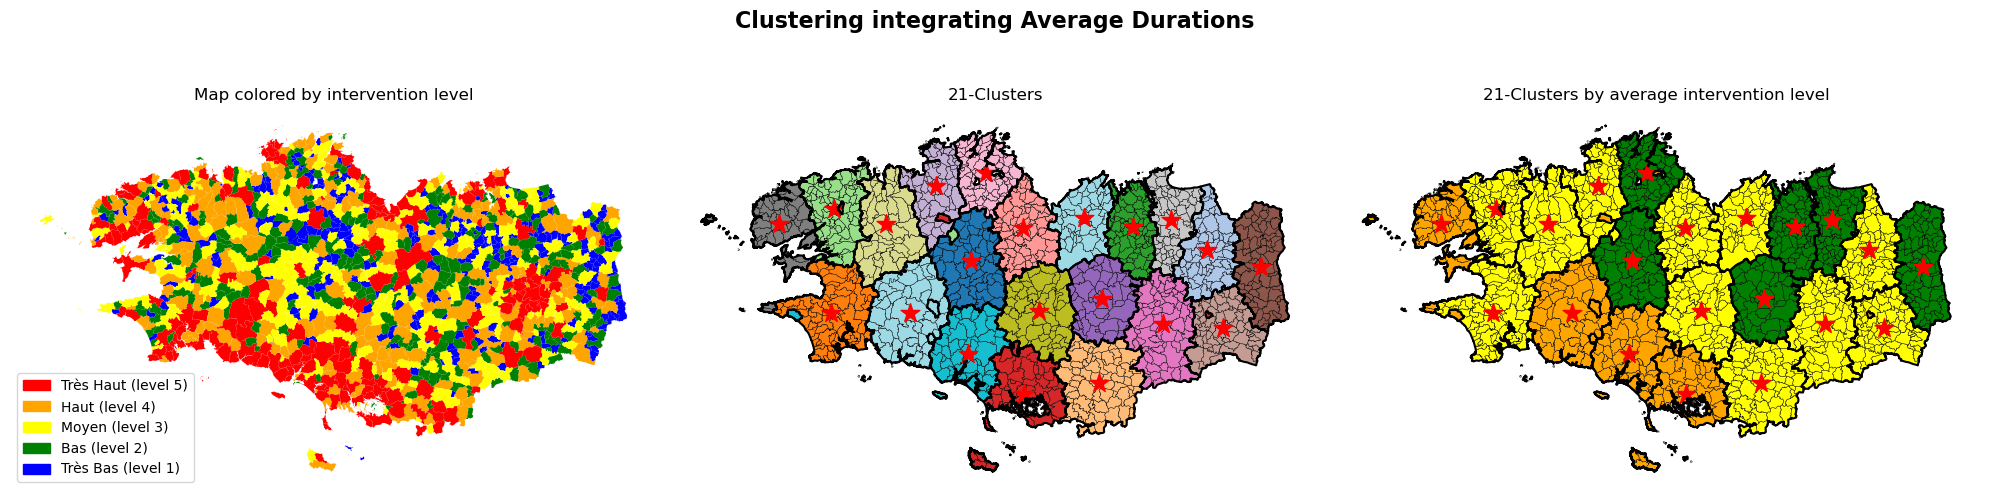

In [513]:
k = 21

# Clustering integrating Average Travel Time
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
kmeans.fit(X, sample_weight=weights_duration)
plot_cluster(kmeans, dfw_geo, X, fig_title="Clustering integrating Average Travel Time")

### III.2.b. Clustering integrating Intervention Level
- We give more influence to communes with longer intervention level
- This adjusts cluster centers to better reflect workload, creating zones that balance geographic proximity and operational effort


Inertia :  95.15026623955346
Calinski Score :  2084.961829944908
Silouhette Score:  0.3441019368303165



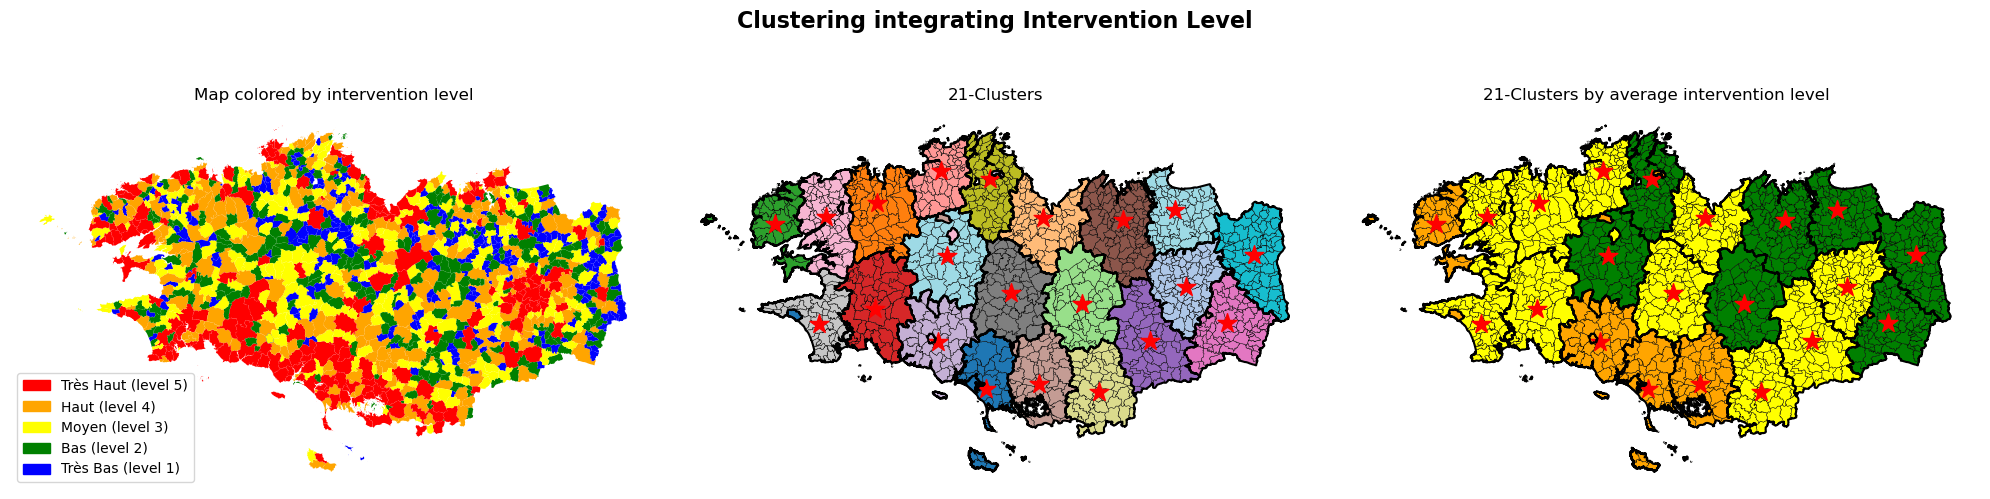

In [512]:
# Clustering integrating Intervention Level
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
kmeans.fit(X, sample_weight=dfw_geo['nivIntervention'])
plot_cluster(kmeans, dfw_geo, X, fig_title="Clustering integrating Intervention Level")

### III.2.c. Clustering integrating Average Travel Time and Intervention Level
- Strongly favors communes with high average response times and high response levels
- Clusters will be influenced by areas with a higher overall operational workload

Inertia :  115334.36299550245
Calinski Score :  2096.0652563063795
Silouhette Score:  0.3436572354746763



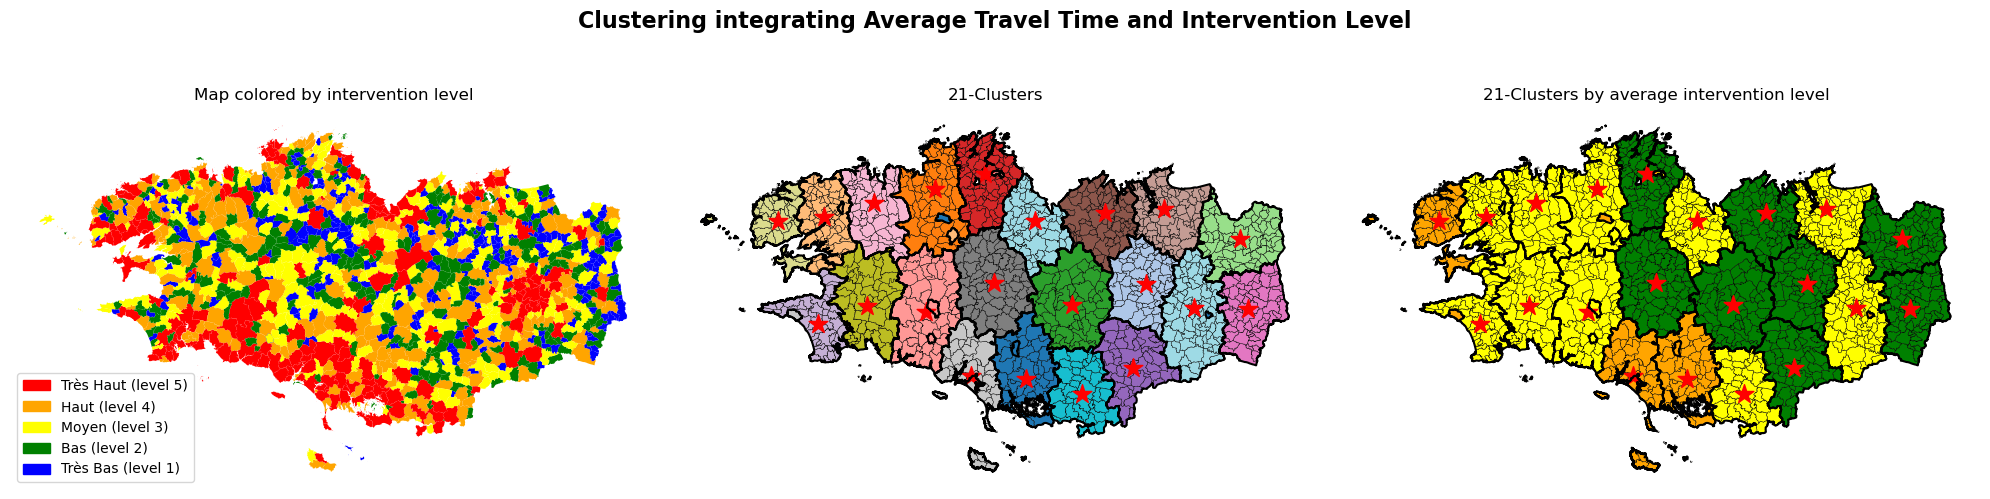

In [522]:
# Clustering integrating Average Travel Time and Intervention Level
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
kmeans.fit(X, sample_weight=weights_duration * dfw_geo['nivIntervention'])
plot_cluster(kmeans, dfw_geo, X, fig_title="Clustering integrating Average Travel Time and Intervention Level")

### III.2.d. Clustering integrating Intervention Level and Penalizing Average Travel Time
- Greater weight is given to communes with a high level of intervention but a low response time
- Clusters give priority to areas where intervention is important but rapid, and minimize the influence of communes that take a long time to intervene.
- Enables smaller clusters to be created, better adapted to actual workloads

Inertia :  0.09435664084540855
Calinski Score :  1919.1631517878807
Silouhette Score:  0.3267561650647594



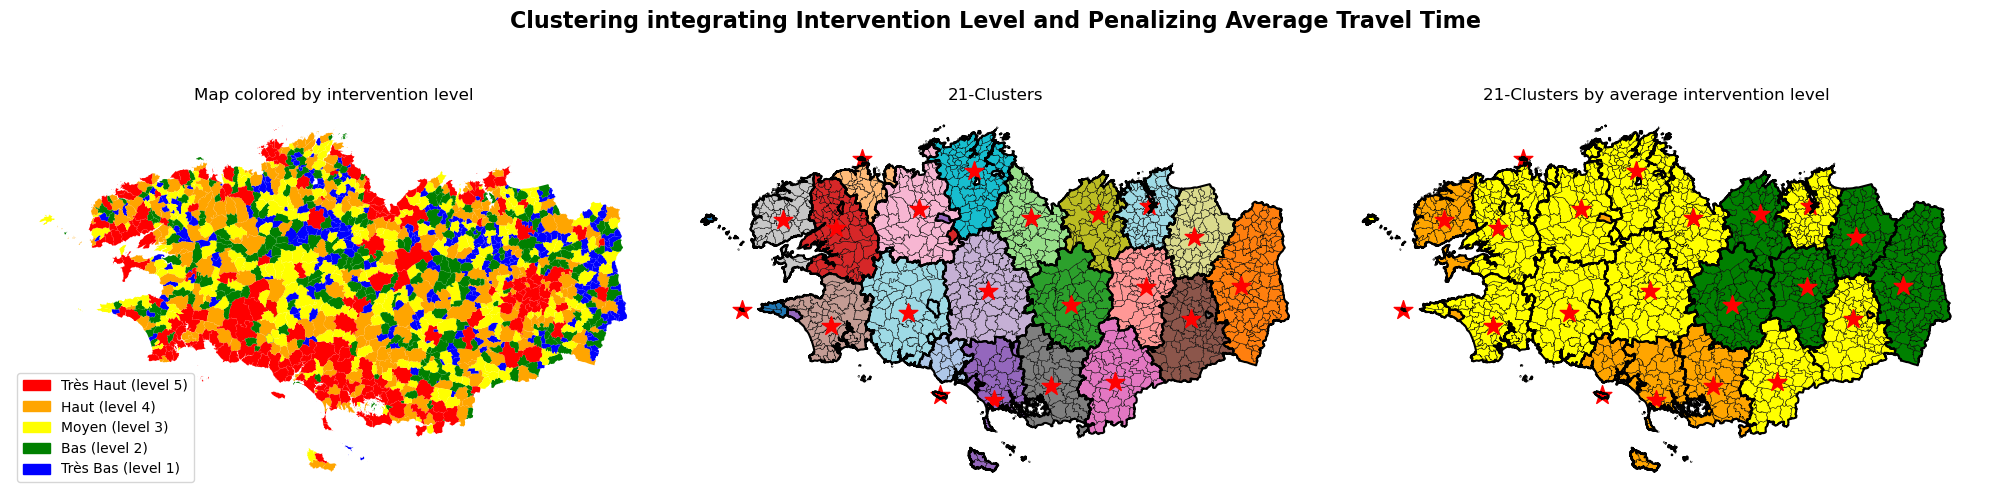

In [523]:
# Clustering integrating Intervention Level and Penalizing Average Travel Time
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
kmeans.fit(X, sample_weight=dfw_geo['nivIntervention'] / (weights_duration + 1e-6))
plot_cluster(kmeans, dfw_geo, X, fig_title="Clustering integrating Intervention Level and Penalizing Average Travel Time")

_______
# IV. Hyperparameter Tuning

We consider the following setting for our model:
```python
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
kmeans.fit(X, sample_weight=dfw_geo['nivIntervention'] / (weights_duration + 1e-6))
``` 

In [532]:
k = 21
kmeans = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42)
weights = dfw_geo['nivIntervention'] / (weights_duration + 1e-6)

In [552]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)
    
param_grid = {
    'n_clusters': range(20, 30),  
    'algorithm': ['lloyd', 'elkan'],
    'init': ['k-means++', 'random'],
    'n_init': [10, 'auto', 20],
    'random_state': range(20, 50, 5)
}

grid_search = GridSearchCV(estimator=kmeans, 
                           param_grid=param_grid, 
                           scoring=silhouette_scorer,
                           cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, sample_weight=weights)

print('GridSearchcy best params: ', grid_search.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
GridSearchcy best params:  {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 28, 'n_init': 10, 'random_state': 30}


Inertia :  0.06621248620708593
Calinski Score :  1937.7952193930446
Silouhette Score:  0.32133059966646244



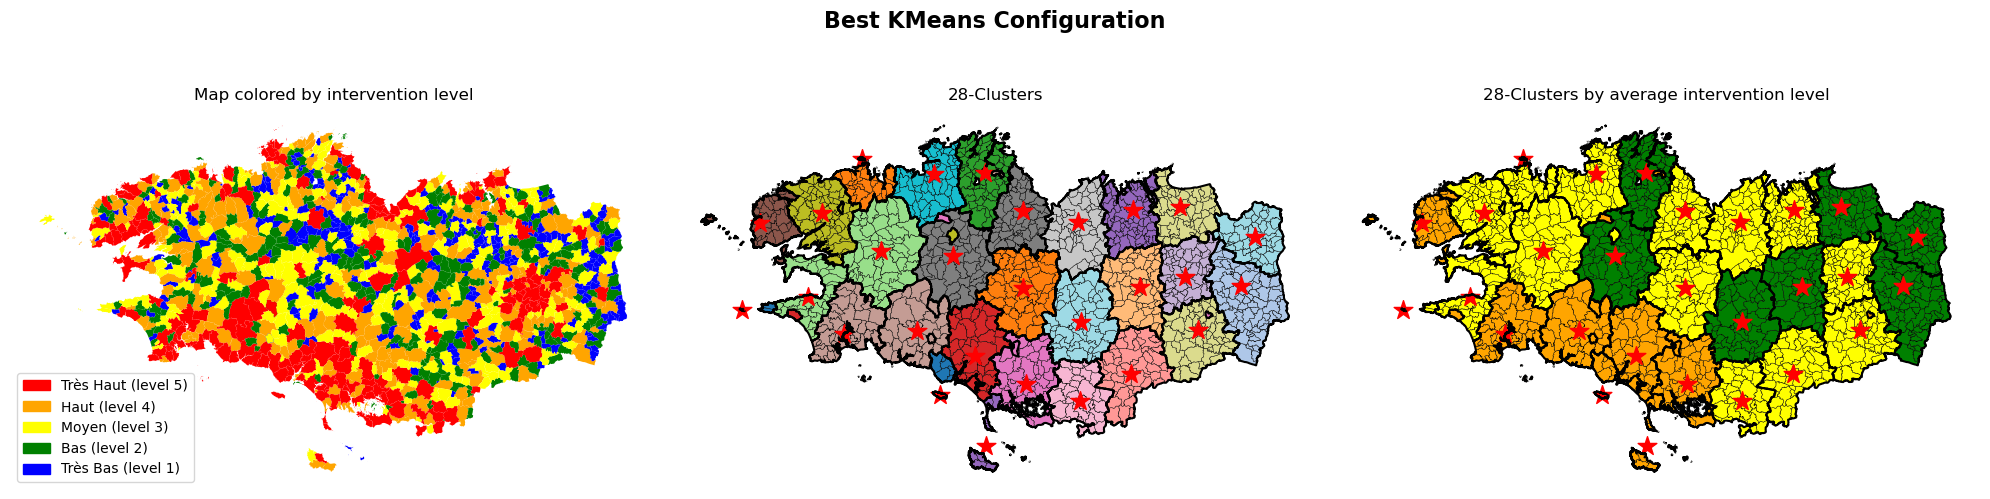

In [553]:
best_kmeans = grid_search.best_estimator_
best_kmeans.fit(X, sample_weight=weights)

plot_cluster(best_kmeans, dfw_geo, X, fig_title="Best KMeans Configuration")